In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.linear_reg
# import from my library file
from my_libs.linear_reg import step_aic_forward, calc_vifs

In [3]:
%config InlineBackend.figure_formats = {'png', 'retina'} #high-reso images
plt.rcParams['font.family'] = 'Yu Mincho' # for Japanese in graph (Win10)

# To show all rows and columns in the results 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
csv_in = 'winequality-red_modified-utf8.txt'
df_all = pd.read_csv(csv_in, delimiter='\s+', skiprows=13, header=0)
print(df_all.shape)
print(df_all.info())
display(df_all.head())

(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1598 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1597 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9        NaN   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0      NaN  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0      NaN  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [5]:
display(df_all.describe())
#display(df_all.describe(exclude='number'))  # no category value columns

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1598.000000          1599.000000           1599.000000  1597.000000   
mean      0.087474            15.874922             46.467792     0.996746   
std       0.047079            10.460157             32.895324     0.001888   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997830   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [6]:
display(df_all[df_all.isnull().any(axis=1)])

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1            7.8              0.88         0.00             2.6      0.098   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9        NaN   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
1                 25.0                  67.0      NaN  3.20       0.68   
3                 17.0                  60.0      NaN  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
1      9.8        5  
3      9.8        6  
4      9.4        5

In [7]:
df_all = df_all.dropna().reset_index(drop=True)
print(df_all.shape)
display(df_all.head())

(1596, 12)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.76         0.04             2.3      0.092   
2            7.4              0.66         0.00             1.8      0.075   
3            7.9              0.60         0.06             1.6      0.069   
4            7.3              0.65         0.00             1.2      0.065   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 15.0                  54.0   0.9970  3.26       0.65   
2                 13.0                  40.0   0.9978  3.51       0.56   
3                 15.0                  59.0   0.9964  3.30       0.46   
4                 15.0                  21.0   0.9946  3.39       0.47   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.4        5  
3      9.4        5  
4     10.0        7

In [8]:
X_all_org = df_all.loc[:, 'fixed_acidity':'alcohol']  # explanatory variables
y = df_all['quality']  # objective variable
print('X_all_org:', X_all_org.shape)
display(X_all_org.head())
print('y:', y.shape)
print(y.head())

X_all_org: (1596, 11)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.76         0.04             2.3      0.092   
2            7.4              0.66         0.00             1.8      0.075   
3            7.9              0.60         0.06             1.6      0.069   
4            7.3              0.65         0.00             1.2      0.065   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 15.0                  54.0   0.9970  3.26       0.65   
2                 13.0                  40.0   0.9978  3.51       0.56   
3                 15.0                  59.0   0.9964  3.30       0.46   
4                 15.0                  21.0   0.9946  3.39       0.47   

   alcohol  
0      9.4  
1      9.8  
2      9.4  
3      9.4  
4     10.0

y: (1596,)
0    5
1    5
2    5
3    5
4    7
Name: quality, dtype: int64


In [9]:
# get_dummies is not needed
X_all = X_all_org.copy()

#X_all = pd.get_dummies(X_all_org, drop_first=True)
#print('X_all:', X_all.shape)
#display(X_all.head())

In [10]:
corr_all = X_all.corr(method='pearson')
display(corr_all)

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.254796     0.671376   
volatile_acidity          -0.254796          1.000000    -0.550864   
citric_acid                0.671376         -0.550864     1.000000   
residual_sugar             0.115231          0.001749     0.143933   
chlorides                  0.094037          0.061071     0.204452   
free_sulfur_dioxide       -0.154094         -0.011231    -0.060859   
total_sulfur_dioxide      -0.113752          0.076463     0.035440   
density                    0.668356          0.022282     0.365623   
pH                        -0.683007          0.234924    -0.542063   
sulphates                  0.183527         -0.261792     0.313457   
alcohol                   -0.061580         -0.202022     0.109363   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.115231   0.094037            -0.154094   
volatile_acidity            0.001749   0.061071            -0.011231   
citric_acid                 0.143933   0.204452            -0.060859   
residual_sugar              1.000000   0.055469             0.187006   
chlorides                   0.055469   1.000000             0.005389   
free_sulfur_dioxide         0.187006   0.005389             1.000000   
total_sulfur_dioxide        0.203091   0.047337             0.667541   
density                     0.355759   0.200882            -0.021855   
pH                         -0.085640  -0.265166             0.071304   
sulphates                   0.005230   0.371164             0.051475   
alcohol                     0.041679  -0.221426            -0.069386   

                      total_sulfur_dioxide   density        pH  sulphates  \
fixed_acidity                    -0.113752  0.668356 -0.683007   0.183527   
volatile_acidity                  0.076463  0.022282  0.234924  -0.261792   
citric_acid                       0.035440  0.365623 -0.542063   0.313457   
residual_sugar                    0.203091  0.355759 -0.085640   0.005230   
chlorides                         0.047337  0.200882 -0.265166   0.371164   
free_sulfur_dioxide               0.667541 -0.021855  0.071304   0.051475   
total_sulfur_dioxide              1.000000  0.071252 -0.065735   0.042895   
density                           0.071252  1.000000 -0.342146   0.148960   
pH                               -0.065735 -0.342146  1.000000  -0.196633   
sulphates                         0.042895  0.148960 -0.196633   1.000000   
alcohol                          -0.205651 -0.495957  0.206091   0.093188   

                       alcohol  
fixed_acidity        -0.061580  
volatile_acidity     -0.202022  
citric_acid           0.109363  
residual_sugar        0.041679  
chlorides            -0.221426  
free_sulfur_dioxide  -0.069386  
total_sulfur_dioxide -0.205651  
density              -0.495957  
pH                    0.206091  
sulphates             0.093188  
alcohol               1.000000

In [11]:
th_corr = 0.3
keep = np.triu(np.ones(corr_all.shape), k=1).astype('bool').flatten()
triu = corr_all.stack()[keep]
triu_sorted = triu[ np.abs(triu).sort_values(ascending=False).index ]
print(triu_sorted[ (triu_sorted < -th_corr) | (triu_sorted > th_corr) ])

fixed_acidity        pH                     -0.683007
                     citric_acid             0.671376
                     density                 0.668356
free_sulfur_dioxide  total_sulfur_dioxide    0.667541
volatile_acidity     citric_acid            -0.550864
citric_acid          pH                     -0.542063
density              alcohol                -0.495957
chlorides            sulphates               0.371164
citric_acid          density                 0.365623
residual_sugar       density                 0.355759
density              pH                     -0.342146
citric_acid          sulphates               0.313457
dtype: float64


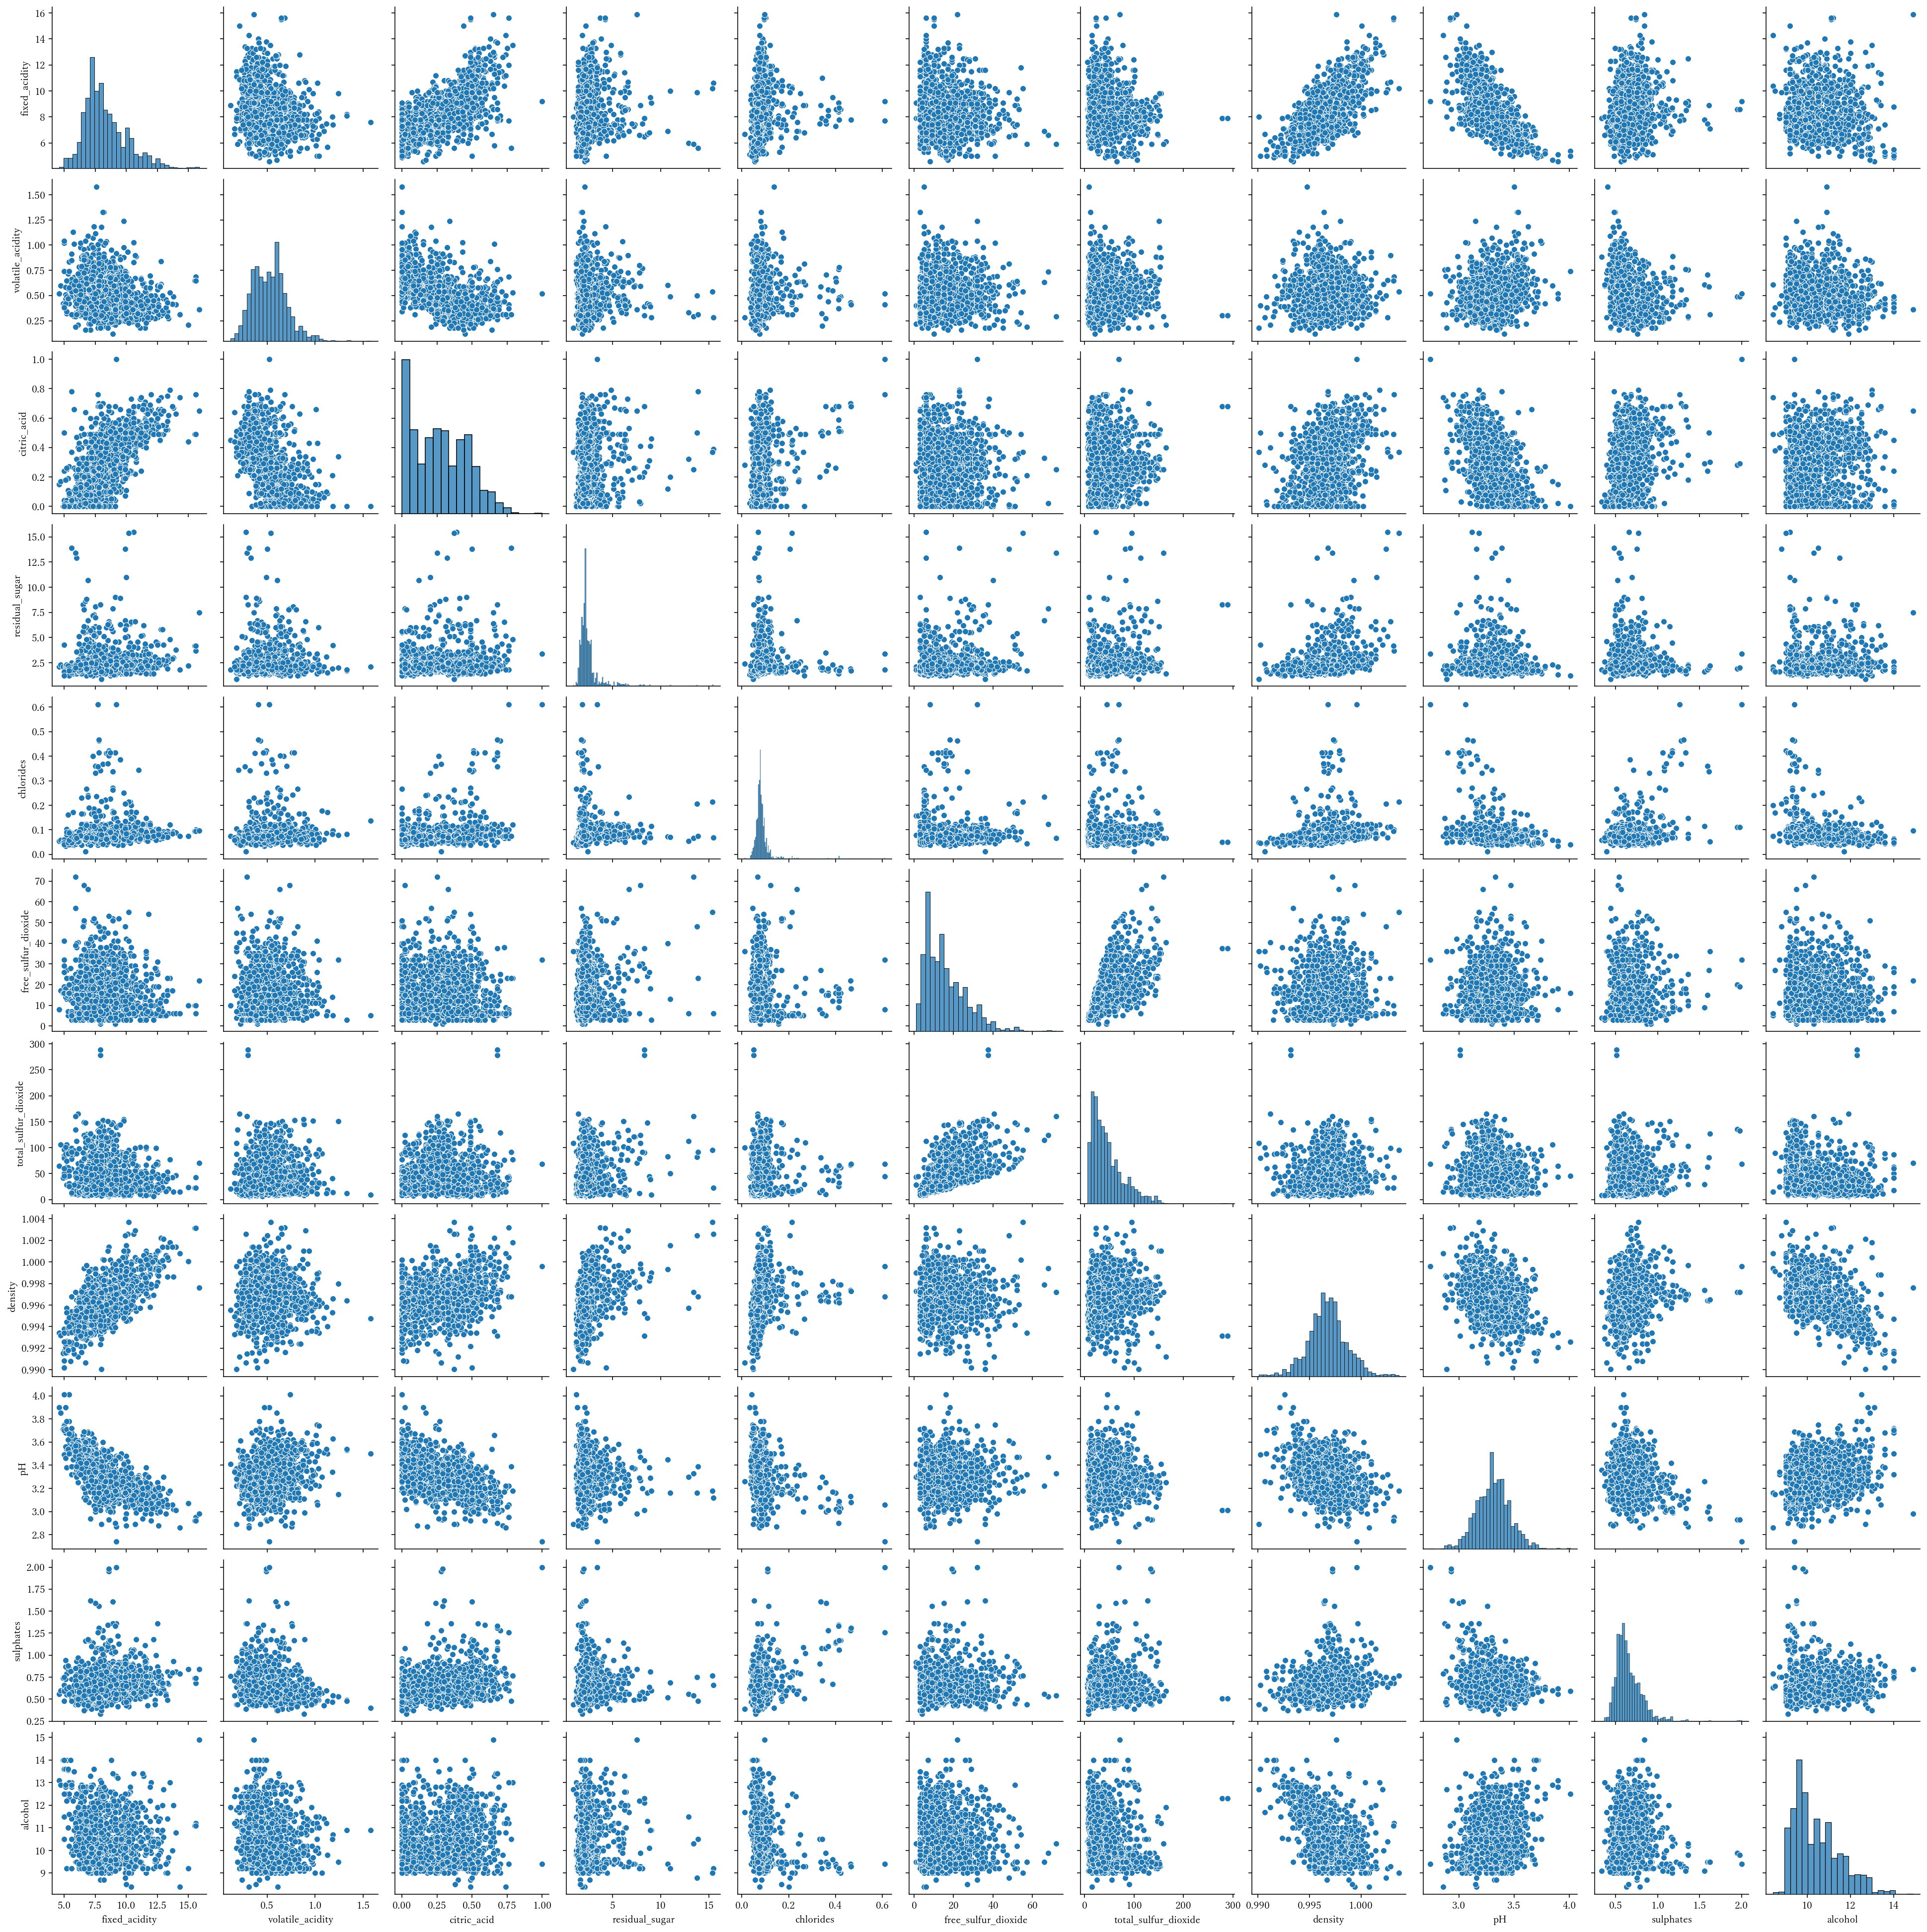

In [12]:
sns.pairplot(X_all)
plt.show()

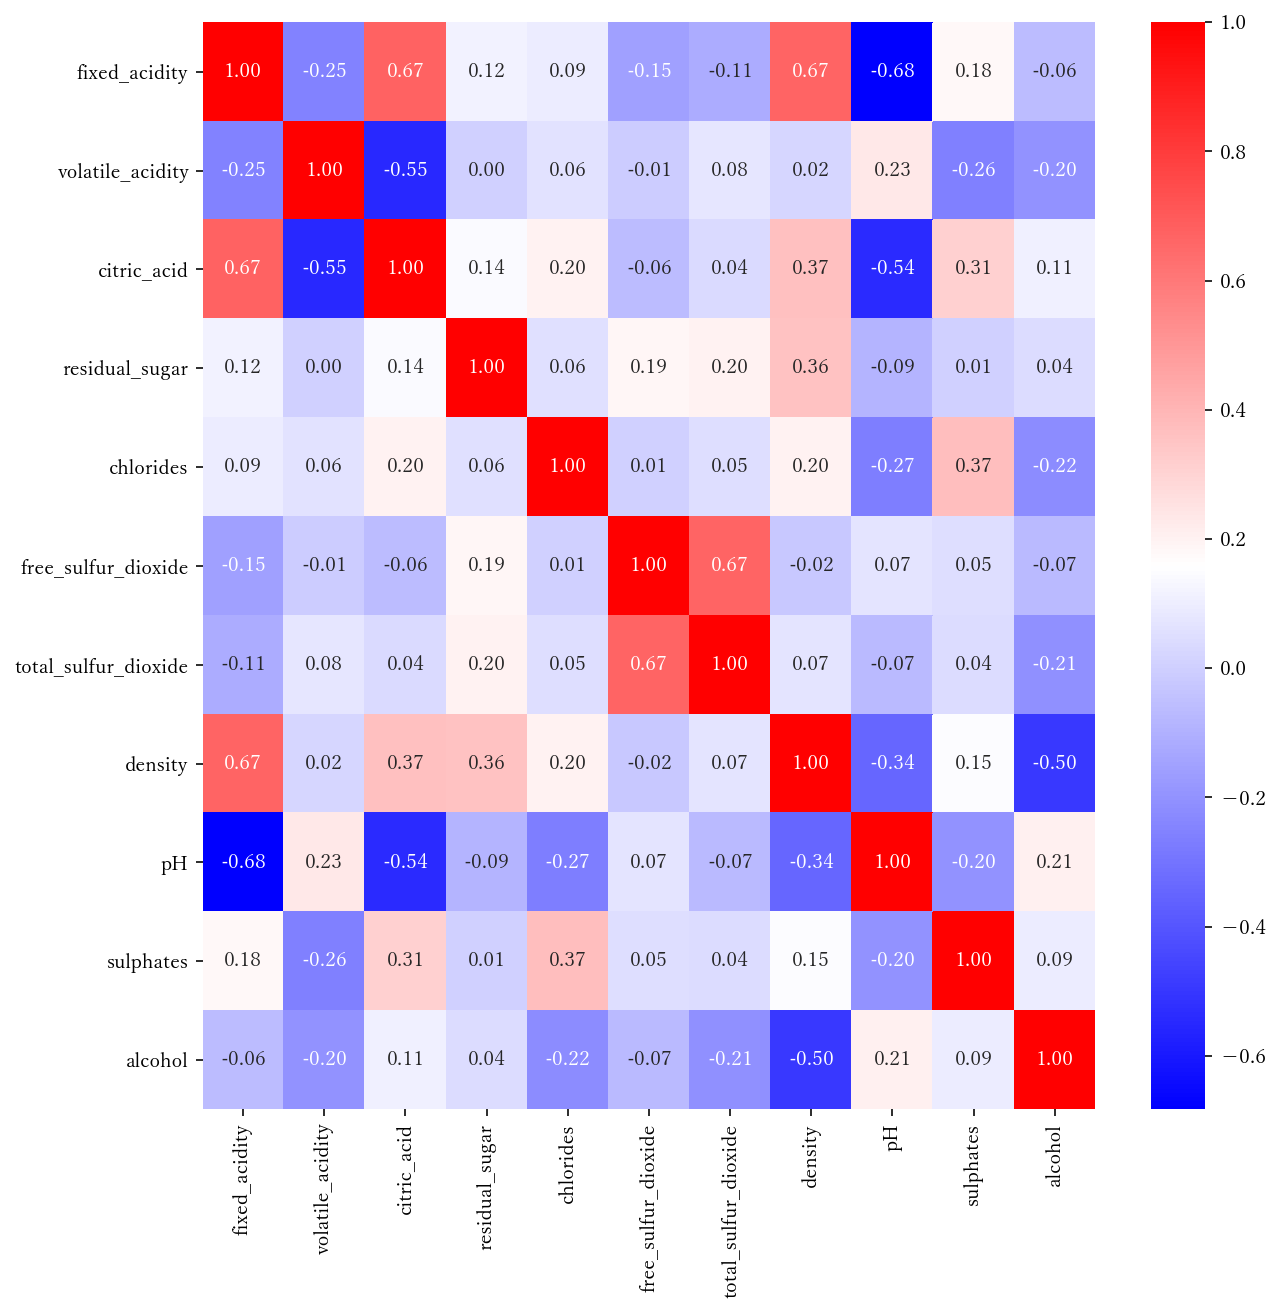

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_all,annot=True,fmt='.2f',cmap='bwr')
plt.show()

In [14]:
X_all_c = sm.add_constant(X_all)
model = sm.OLS(y, X_all_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.03
Date:                Thu, 03 Jun 2021   Prob (F-statistic):          6.17e-145
Time:                        15:26:46   Log-Likelihood:                -1567.6
No. Observations:                1596   AIC:                             3159.
Df Residuals:                    1584   BIC:                             3224.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.6728 

In [15]:
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)

R2: 0.3600832139208682
Adj R2: 0.3556393473508742


In [16]:
print('p-values (F-statistic)', results.f_pvalue)

p-values (F-statistic) 6.1687486357125506e-145


In [17]:
# NOTE: after scaling, X_scaled and Y_scaled are ndarray, not DataFrame.
X_scaled = preprocessing.scale(X_all)
y_scaled = preprocessing.scale(y)
model = sm.OLS(y_scaled, X_scaled)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.360
Model:                            OLS   Adj. R-squared (uncentered):              0.356
Method:                 Least Squares   F-statistic:                              81.08
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                   4.95e-145
Time:                        15:27:58   Log-Likelihood:                         -1908.4
No. Observations:                1596   AIC:                                      3839.
Df Residuals:                    1585   BIC:                                      3898.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
# NOTE: make DataFrames corresponding to X_scaled and y_scaled.
dfX_scaled = pd.DataFrame(X_scaled, columns=X_all.columns)
dfy_scaled = pd.Series(y_scaled, name=y.name)
exog = list(dfX_scaled.columns)  # Initial set = all explanatory variables
endog = [dfy_scaled.name]  # Objective variables
df_scaled = pd.concat([dfX_scaled, dfy_scaled], axis=1)

In [19]:
results_aic=step_aic_forward(smf.ols, exog, endog, data=df_scaled)


AIC: 4531.252, formula: quality ~ 1
AIC: 4528.011, formula: quality ~ pH
AIC: 4123.148, formula: quality ~ alcohol
AIC: 4270.337, formula: quality ~ volatile_acidity
AIC: 4532.954, formula: quality ~ residual_sugar
AIC: 4506.508, formula: quality ~ chlorides
AIC: 4450.253, formula: quality ~ citric_acid
AIC: 4529.172, formula: quality ~ free_sulfur_dioxide
AIC: 4508.780, formula: quality ~ fixed_acidity
AIC: 4428.999, formula: quality ~ sulphates
AIC: 4477.538, formula: quality ~ total_sulfur_dioxide
AIC: 4483.646, formula: quality ~ density
AIC: 4072.263, formula: quality ~ alcohol + pH
AIC: 3928.074, formula: quality ~ alcohol + volatile_acidity
AIC: 4125.070, formula: quality ~ alcohol + residual_sugar
AIC: 4123.949, formula: quality ~ alcohol + chlorides
AIC: 4061.342, formula: quality ~ alcohol + citric_acid
AIC: 4124.514, formula: quality ~ alcohol + free_sulfur_dioxide
AIC: 4076.123, formula: quality ~ alcohol + fixed_acidity
AIC: 4033.266, formula: quality ~ alcohol + sulphates

In [20]:
print(results_aic.aic)
print(results_aic.model.exog_names)
print(results_aic.model.endog_names)

3835.4763012244853
['Intercept', 'alcohol', 'volatile_acidity', 'sulphates', 'total_sulfur_dioxide', 'chlorides', 'pH', 'free_sulfur_dioxide']
quality


In [21]:
endogs = results_aic.model.endog_names
exogs = results_aic.model.exog_names.copy()
exogs.remove('Intercept')
#print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

VIF
const                 618.539992
alcohol                 1.220248
volatile_acidity        1.242579
sulphates               1.322258
total_sulfur_dioxide    1.943518
chlorides               1.333407
pH                      1.255038
free_sulfur_dioxide     1.882888

In [22]:
# all VIFs < 10, so removal of variables is not needed
#exogs.remove('w_all')
#exogs.remove('w_meat')
#exogs.remove('w_shell')
#print(exogs)  # debug
#X_c = sm.add_constant(X_all[exogs])
#vifs = calc_vifs(X_c, y)
#display(vifs)

In [23]:
X_final_scaled = dfX_scaled[exogs]
model_final_scaled = sm.OLS(y_scaled, X_final_scaled)
results_final_scaled = model_final_scaled.fit()
print(results_final_scaled.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.359
Model:                            OLS   Adj. R-squared (uncentered):              0.356
Method:                 Least Squares   F-statistic:                              127.1
Date:                Thu, 03 Jun 2021   Prob (F-statistic):                   1.48e-148
Time:                        15:29:39   Log-Likelihood:                         -1909.7
No. Observations:                1596   AIC:                                      3833.
Df Residuals:                    1589   BIC:                                      3871.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [24]:
print(results_final_scaled.params)

alcohol                 0.381874
volatile_acidity       -0.223534
sulphates               0.185601
total_sulfur_dioxide   -0.142075
chlorides              -0.117664
pH                     -0.092192
free_sulfur_dioxide     0.065957
dtype: float64


In [25]:
print('p-values (F-statistic)', results_final_scaled.f_pvalue)

p-values (F-statistic) 1.4839271358965758e-148


In [26]:
X_final_c = sm.add_constant(X_all[exogs])
model_final = sm.OLS(y, X_final_c)
results_final = model_final.fit()
print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     127.1
Date:                Thu, 03 Jun 2021   Prob (F-statistic):          1.85e-148
Time:                        15:30:31   Log-Likelihood:                -1568.9
No. Observations:                1596   AIC:                             3154.
Df Residuals:                    1588   BIC:                             3197.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.4260 

In [27]:
print('R2:', results_final.rsquared)
print('Adj R2:', results_final.rsquared_adj)

R2: 0.3589972226304373
Adj R2: 0.3561716436369947


In [28]:
print(results_final.params)

const                   4.426027
alcohol                 0.289401
volatile_acidity       -1.009819
sulphates               0.884003
total_sulfur_dioxide   -0.003487
chlorides              -2.018132
pH                     -0.482495
free_sulfur_dioxide     0.005091
dtype: float64
